In [18]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import InceptionV3
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 64
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Rice_Leaf_Disease_Images",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 7795 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Bacterialblight', 'Blast', 'Brownspot', 'Healthy', 'Tungro']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 256, 256, 3)
[2 2 0 0 0 1 3 3 0 2 2 2 1 3 1 0 1 4 2 1 0 4 3 0 0 4 4 1 3 1 1 3 0 3 2 4 0
 4 2 2 1 3 4 3 0 1 0 1 3 4 4 3 3 2 1 2 1 2 2 1 3 3 0 1]


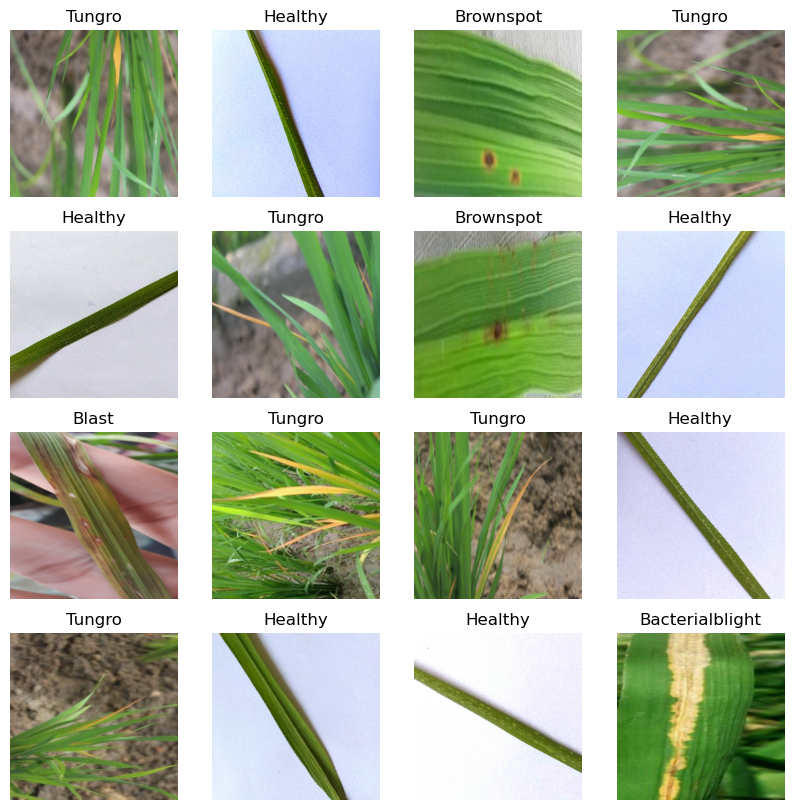

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [11]:
data_aug = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
# Create the InceptionNet model
base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
)

87924736/87910968 [==============================] - 31s 0us/step


In [20]:
# Freeze the base model
base_model.trainable = False

# Add custom classification layers on top of the base model
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = resize_and_rescale(inputs)
x = data_aug(x)
x = base_model(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      multiple                  0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4718656   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325   

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/50
97/97 [==============================] - 126s 726ms/step - loss: 1.6860 - accuracy: 0.8150 - val_loss: 0.3401 - val_accuracy: 0.9232
Epoch 2/50
97/97 [==============================] - 24s 250ms/step - loss: 0.2204 - accuracy: 0.9443 - val_loss: 0.4365 - val_accuracy: 0.8997
Epoch 3/50
97/97 [==============================] - 18s 189ms/step - loss: 0.2254 - accuracy: 0.9508 - val_loss: 0.2261 - val_accuracy: 0.9544
Epoch 4/50
97/97 [==============================] - 18s 189ms/step - loss: 0.1863 - accuracy: 0.9593 - val_loss: 0.1852 - val_accuracy: 0.9531
Epoch 5/50
97/97 [==============================] - 18s 187ms/step - loss: 0.1343 - accuracy: 0.9669 - val_loss: 0.1304 - val_accuracy: 0.9648
Epoch 6/50
97/97 [==============================] - 18s 188ms/step - loss: 0.1310 - accuracy: 0.9676 - val_loss: 0.1370 - val_accuracy: 0.9648
Epoch 7/50
97/97 [==============================] - 18s 187ms/step - loss: 0.1139 - accuracy: 0.9692 - val_loss: 0.1620 - val_accuracy: 0.962

In [24]:
scores = model.evaluate(test_ds)

13/13 [==============================] - 45s 162ms/step - loss: 0.0908 - accuracy: 0.9784


In [25]:
scores

[0.09080631285905838, 0.9783653616905212]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 97}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
type(history.history['loss'])

list

In [30]:
len(history.history['loss'])

50

In [31]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.6860276460647583,
 0.22042012214660645,
 0.2253546118736267,
 0.18629196286201477,
 0.13432163000106812]

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

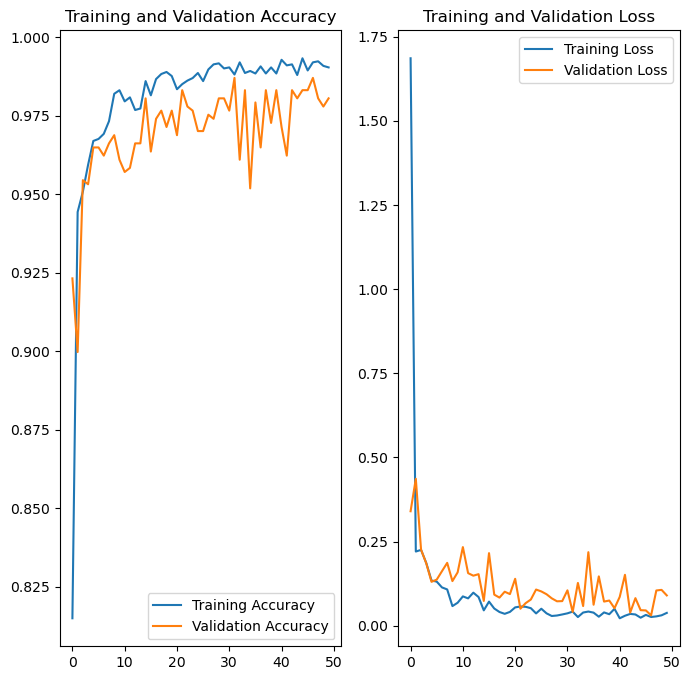

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Healthy
predicted label: Healthy


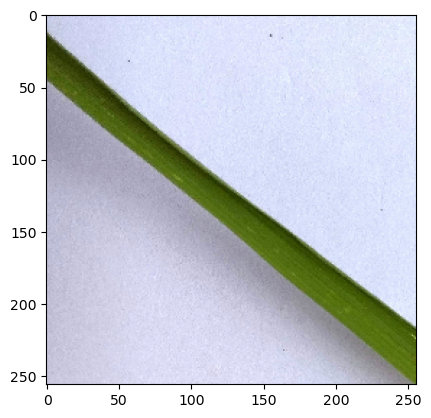

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

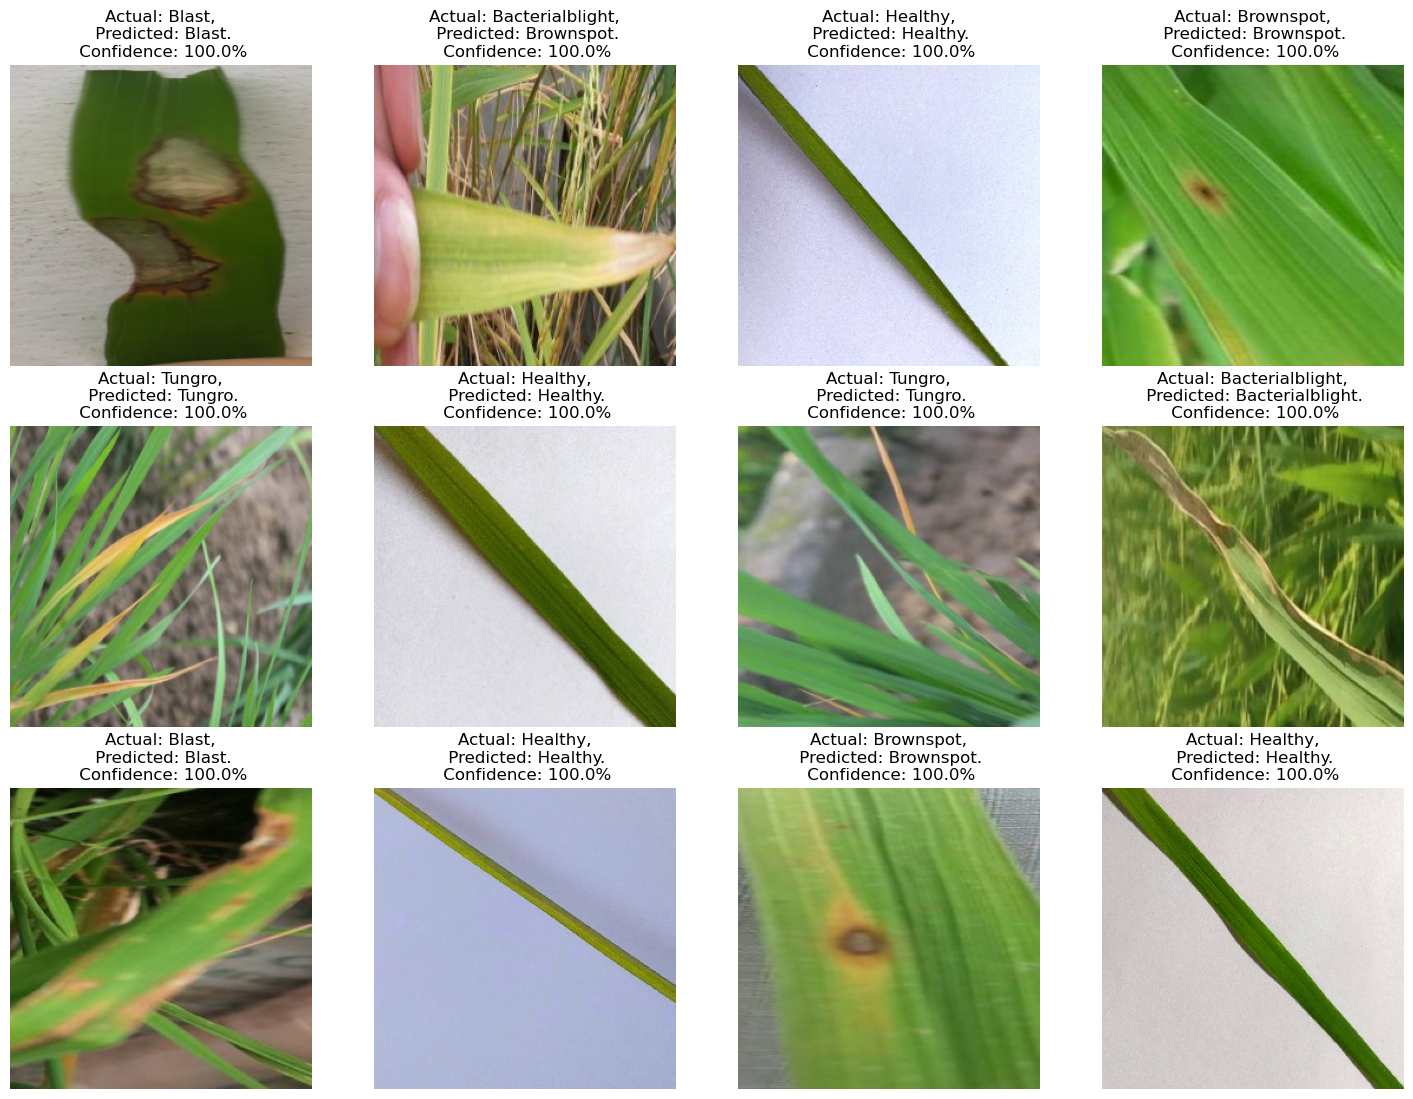

In [37]:
plt.figure(figsize=(18, 18))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [38]:
import os
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/4\assets


In [39]:
model.save("../rice_inceptionNet.h5")